# Deep Neural Network for Image Classification: Application

**After this assignment you will be able to:**

- Build and train a deep L-layer neural network, and apply it to supervised learning

Let's get started!

## Table of Contents
- [1 - Packages](#1)
- [2 - Load and Process the Dataset](#2)
- [3 - Model Architecture](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
    - [3.2 - L-layer Deep Neural Network](#3-2)
    - [3.3 - General Methodology](#3-3)
- [4 - Two-layer Neural Network](#4)
    - [Exercise 1 - two_layer_model](#ex-1)
    - [4.1 - Train the model](#4-1)
- [5 - L-layer Neural Network](#5)
    - [Exercise 2 - L_layer_model](#ex-2)
    - [5.1 - Train the model](#5-1)
- [6 - Results Analysis](#6)
- [7 - Test with your own image (optional/ungraded exercise)](#7)

<a name='1'></a>
## 1 - Packages

Begin by importing all the packages you'll need during this assignment. 

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- `dnn_app_utils` provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- `np.random.seed(1)` is used to keep all the random function calls consistent. It helps grade your work - so please don't change it! 

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *
#from public_tests import *
from IPython.display import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
# dnn_app_utils_v3


def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters     


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [3]:
# test_utils

def datatype_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in expected_output.keys():
            try:
                success += datatype_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} in variable {}. Got {} but expected type {}".format(error,
                                                                          key, type(target_output[key]), type(expected_output[key])))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(expected_output)):
            try: 
                success += datatype_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} in variable {}. Got type: {}  but expected type {}".format(error,
                                                                          i, type(target_output[i]), type(expected_output[i])))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        assert isinstance(target_output, type(expected_output))
        return 1
            
def equation_output_check(expected_output, target_output, error):
    success = 0
    if isinstance(expected_output, dict):
        for key in expected_output.keys():
            try:
                success += equation_output_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error,
                                                                          key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(expected_output, tuple) or isinstance(expected_output, list):
        for i in range(len(expected_output)):
            try: 
                success += equation_output_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(expected_output, 'shape'):
            #np.allclose(target_output, expected_output)
            np.testing.assert_array_almost_equal(target_output, expected_output)
        else:
            assert target_output == expected_output
        return 1
    
def shape_check(expected_output, target_output, error):
    success = 0
    if isinstance(expected_output, dict):
        for key in expected_output.keys():
            try:
                success += shape_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(expected_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(expected_output, tuple) or isinstance(expected_output, list):
        for i in range(len(expected_output)):
            try: 
                success += shape_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(expected_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(expected_output, 'shape'):
            assert target_output.shape == expected_output.shape
        return 1
                
def single_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            if test_case['name'] == "datatype_check":
                assert isinstance(target(*test_case['input']),
                                  type(test_case["expected"]))
                success += 1
            if test_case['name'] == "equation_output_check":
                assert np.allclose(test_case["expected"],
                                   target(*test_case['input']))
                success += 1
            if test_case['name'] == "shape_check":
                assert test_case['expected'].shape == target(*test_case['input']).shape
                success += 1
        except:
            print("Error: " + test_case['error'])
            
    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))
        
def multiple_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            target_answer = target(*test_case['input'])                   
            if test_case['name'] == "datatype_check":
                success += datatype_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "equation_output_check":
                success += equation_output_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "shape_check":
                success += shape_check(test_case['expected'], target_answer, test_case['error'])
        except:
            print("Error: " + test_case['error'])
            
    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))
        

In [4]:
# public_tests
         
def two_layer_model_test(target):
    np.random.seed(1)
    n_x = 10
    n_h = 4
    n_y = 1
    num_examples = 10
    num_iterations = 2
    layers_dims = (n_x, n_h, n_y)
    learning_rate = 0.0075
    X = np.random.randn(n_x, num_examples)
    Y = np.random.randn(1, num_examples)
    
    expected_parameters = {'W1': np.array([[ 0.01624965, -0.00610741, -0.00528734, -0.01072836,  0.008664  ,
                                 -0.02301103,  0.01745639, -0.00760949,  0.0031934 , -0.00248971],
                                [ 0.01462848, -0.02057904, -0.00326745, -0.00383625,  0.01138176,
                                 -0.01097596, -0.00171974, -0.00877601,  0.00043022,  0.00584423],
                                [-0.01098272,  0.01148209,  0.00902102,  0.00500958,  0.00900571,
                                 -0.00683188, -0.00123491, -0.00937164, -0.00267157,  0.00532808],
                                [-0.00693465, -0.00400047, -0.00684685, -0.00844447, -0.00670397,
                                 -0.00014731, -0.01113977,  0.00238846,  0.0165895 ,  0.00738212]]),
                         'b1': np.array([[ 1.10437111e-05],
                                [ 1.78437869e-05],
                                [ 3.74879549e-05],
                                [-4.42988824e-05]]),
                         'W2': np.array([[-0.00200283, -0.00888593, -0.00751122,  0.01688162]]),
                         'b2': np.array([[-0.00689018]])}
    expected_costs = [np.array(0.69315968)]
    
    expected_output1 = (expected_parameters, expected_costs)
    
    expected_output2 = ({'W1': np.array([[ 0.01640028, -0.00585699, -0.00542633, -0.01069332,  0.0089055 ,
        -0.02290418,  0.01765388, -0.00754616,  0.00326712, -0.00239159],
       [ 0.01476737, -0.02014461, -0.0040947 , -0.0037457 ,  0.01221714,
        -0.01054049, -0.00164111, -0.00872507,  0.00058592,  0.00615077],
       [-0.01051621,  0.01216499,  0.009119  ,  0.0047126 ,  0.00894761,
        -0.00672568, -0.00134921, -0.0096428 , -0.00253223,  0.00580758],
       [-0.00728552, -0.00461461, -0.00638113, -0.00831084, -0.00654136,
        -0.00053186, -0.01052771,  0.00320719,  0.01643914,  0.00667123]]), 
       'b1': np.array([[ 0.00027478],
       [ 0.00034477],
       [ 0.00076016],
       [-0.00084497]]), 
       'W2': np.array([[-0.00358725, -0.00911995, -0.00831979,  0.01615845]]), 
       'b2': np.array([[-0.13451354]])}, [np.array(0.69315968)])
    
    test_cases = [
        {
            "name":"datatype_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error":"Datatype mismatch."
        },
        {
            "name": "shape_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong shape"
        },
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong output"
        },
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, 0.1, 3],
            "expected": expected_output2,
            "error": "Wrong output"
        }
    ]
    
    multiple_test(test_cases, target)
    
            
        
def L_layer_model_test(target):
    np.random.seed(1)
    n_x = 10 
    n_y = 1
    num_examples = 10
    num_iterations = 2
    layers_dims = (n_x, 5, 6 , n_y)
    learning_rate = 0.0075
    X = np.random.randn(n_x, num_examples)
    Y = np.array([1,1,1,1,0,0,0,1,1,0]).reshape(1,10)
    
    expected_parameters = {'W1': np.array([[ 0.51384638, -0.19333098, -0.16705238, -0.33923196,  0.273477  ,
         -0.72775498,  0.55170785, -0.24077478,  0.10082452, -0.07882423],
        [ 0.46227786, -0.65153639, -0.10192959, -0.12150984,  0.35855025,
         -0.34787253, -0.05455001, -0.27767163,  0.01337835,  0.1843845 ],
        [-0.34790478,  0.36200264,  0.28511245,  0.15868454,  0.284931  ,
         -0.21645471, -0.03877896, -0.29584578, -0.08480802,  0.16760667],
        [-0.21835973, -0.12531366, -0.21720823, -0.26764975, -0.21214946,
         -0.00438229, -0.35316347,  0.07432144,  0.52474685,  0.23453653],
        [-0.06060968, -0.28061463, -0.23624839,  0.53526844,  0.01597194,
         -0.20136496,  0.06021639,  0.66414167,  0.03804666,  0.19528599]]),
 'b1': np.array([[-2.16491028e-04],
        [ 1.50999130e-04],
        [ 8.71516045e-06],
        [ 5.57557615e-05],
        [-2.90746349e-05]]),
 'W2': np.array([[ 0.13428358, -0.15747685, -0.51095667, -0.15624083, -0.09342034],
        [ 0.26226685,  0.3751336 ,  0.41644174,  0.12779375,  0.39573817],
        [-0.33726917,  0.56041154,  0.22939257, -0.1333337 ,  0.21851314],
        [-0.03377599,  0.50617255,  0.67960046,  0.97726521, -0.62458844],
        [-0.64581803, -0.22559264,  0.0715349 ,  0.39173682,  0.14112904],
        [-0.9043503 , -0.13693179,  0.37026002,  0.10284282,  0.34076545]]),
 'b2': np.array([[ 1.80215514e-07],
        [-1.07935097e-04],
        [ 1.63081605e-04],
        [-3.51202008e-05],
        [-7.40012619e-05],
        [-4.43814901e-05]]),
 'W3': np.array([[-0.09079199, -0.08117381,  0.07667568,  0.16665535,  0.08029575,
          0.04805811]]),
 'b3': np.array([[0.0013201]])}
    expected_costs = [np.array(0.70723944)]
    
    expected_output1 = (expected_parameters, expected_costs)
    expected_output2 = ({'W1': np.array([[ 0.51439065, -0.19296367, -0.16714033, -0.33902173,  0.27291558,
                -0.72759069,  0.55155832, -0.24095201,  0.10063293, -0.07872596],
               [ 0.46203186, -0.65172685, -0.10184775, -0.12169458,  0.35861847,
                -0.34804029, -0.05461748, -0.27787524,  0.01346693,  0.18463095],
               [-0.34748255,  0.36202977,  0.28512463,  0.1580327 ,  0.28509518,
                -0.21717447, -0.03853304, -0.29563725, -0.08509025,  0.16728901],
               [-0.21727997, -0.12486465, -0.21692552, -0.26875722, -0.21180188,
                -0.00550575, -0.35268367,  0.07489501,  0.52436384,  0.23418418],
               [-0.06045008, -0.28038304, -0.23617868,  0.53546925,  0.01569291,
                -0.20115358,  0.05975429,  0.66409149,  0.03819309,  0.1956102 ]]), 
                         'b1': np.array([[-8.61228305e-04],
               [ 6.08187689e-04],
               [ 3.53075377e-05],
               [ 2.21291877e-04],
               [-1.13591429e-04]]), 
                         'W2': np.array([[ 0.13441428, -0.15731437, -0.51097778, -0.15627102, -0.09342034],
               [ 0.2620349 ,  0.37492336,  0.4165605 ,  0.12801536,  0.39541677],
               [-0.33694339,  0.56075022,  0.22940292, -0.1334017 ,  0.21863717],
               [-0.03371679,  0.50644769,  0.67935577,  0.97680859, -0.62475679],
               [-0.64579072, -0.22555897,  0.07142896,  0.3914475 ,  0.14104814],
               [-0.90433399, -0.13691167,  0.37019673,  0.10266999,  0.34071712]]), 
                         'b2': np.array([[ 1.18811550e-06],
               [-4.25510194e-04],
               [ 6.56178455e-04],
               [-1.42335482e-04],
               [-2.93618626e-04],
               [-1.75573157e-04]]), 
                         'W3': np.array([[-0.09087434, -0.07882982,  0.07821609,  0.16442826,  0.0783229 ,
                 0.04648216]]), 
                         'b3': np.array([[0.00525865]])}, [np.array(0.70723944)])
    
    test_cases = [
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong output"
        },
        {
            "name":"datatype_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error":"Datatype mismatch."
        },
        {
            "name": "shape_check",
            "input": [X, Y, layers_dims, learning_rate, num_iterations],
            "expected": expected_output1,
            "error": "Wrong shape"
        },
        {
            "name": "equation_output_check",
            "input": [X, Y, layers_dims, 0.02, 3],
            "expected": expected_output2,
            "error": "Wrong output"
        },
    ]
    
    multiple_test(test_cases, target)



<a name='2'></a>
## 2 - Load and Process the Dataset

You'll be using the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you built back then had 70% test accuracy on classifying cat vs non-cat images. Hopefully, your new model will perform even better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of `m_train` images labelled as cat (1) or non-cat (0)
    - a test set of `m_test` images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [5]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to check out other images. 

y = 0. It's a non-cat picture.


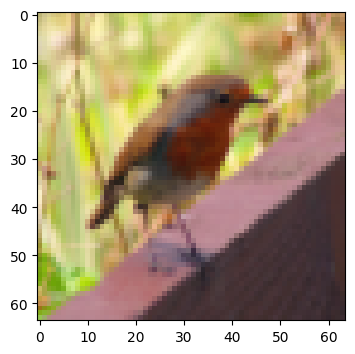

In [6]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [7]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

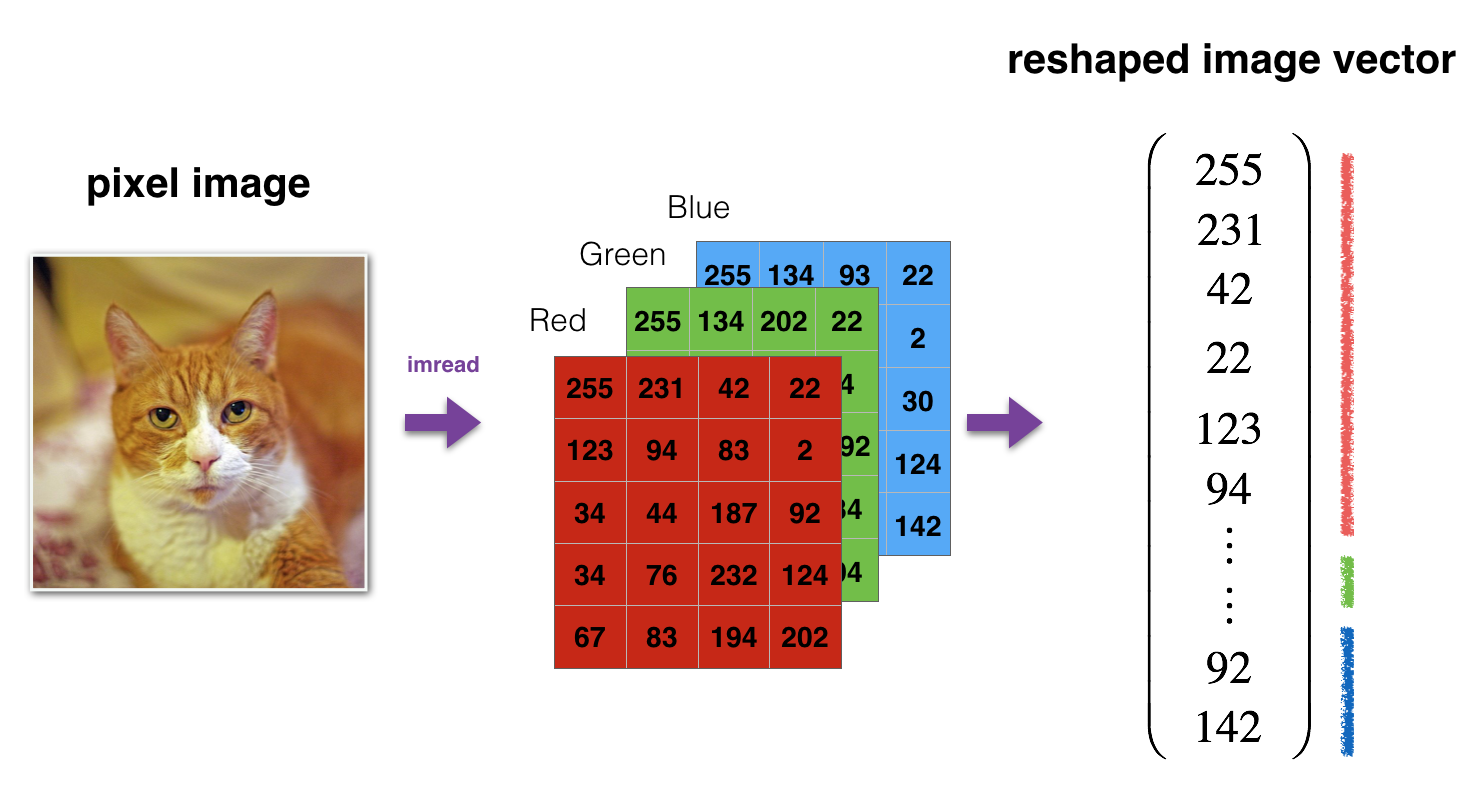

<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [8]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

<a name='3'></a>
## 3 - Model Architecture

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

Now that you're familiar with the dataset, it's time to build a deep neural network to distinguish cat images from non-cat images!

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, you'll compare the performance of these models, and try out some different values for $L$. 

Let's look at the two architectures:
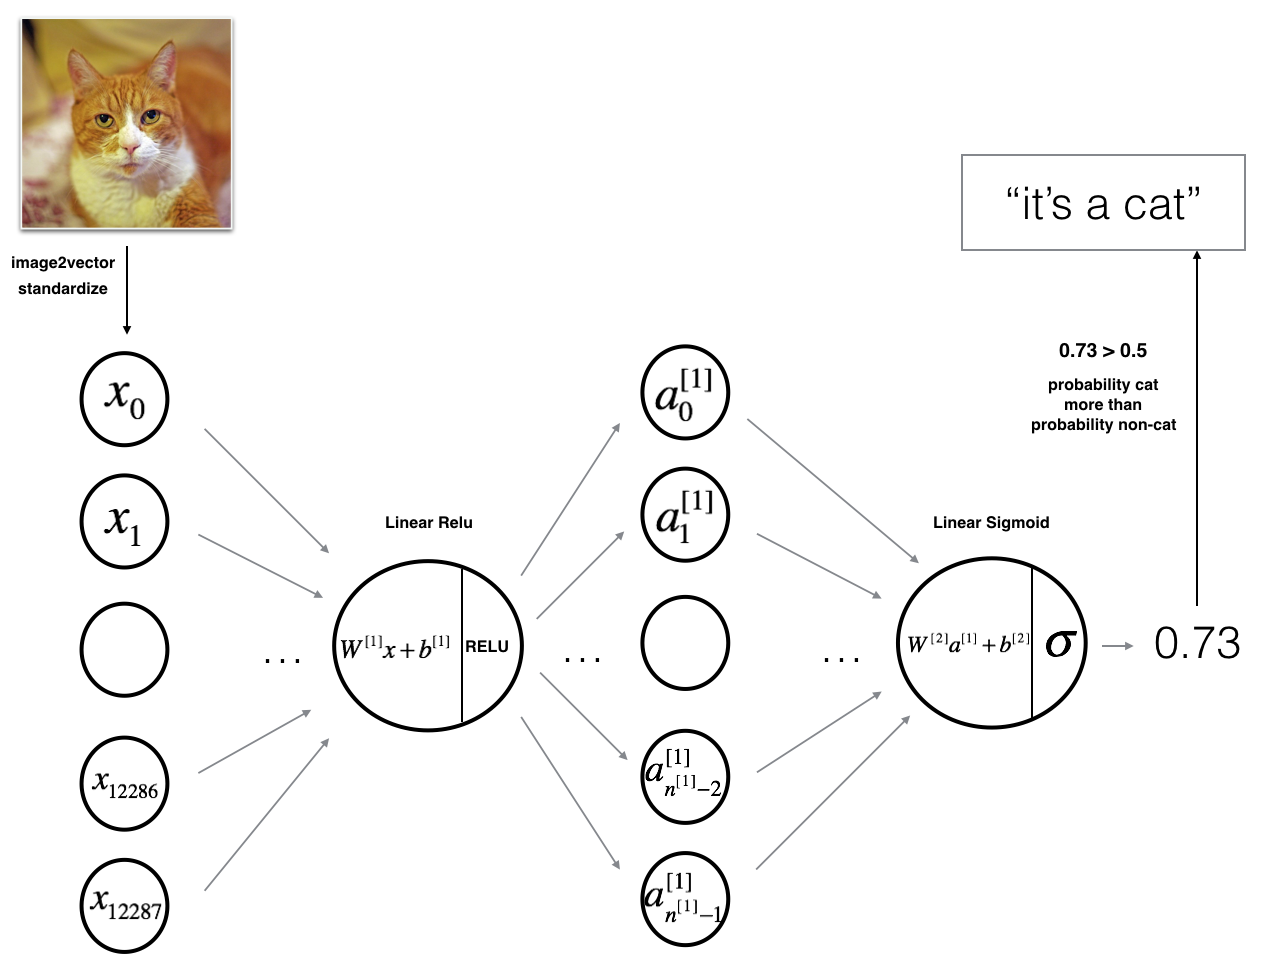

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:
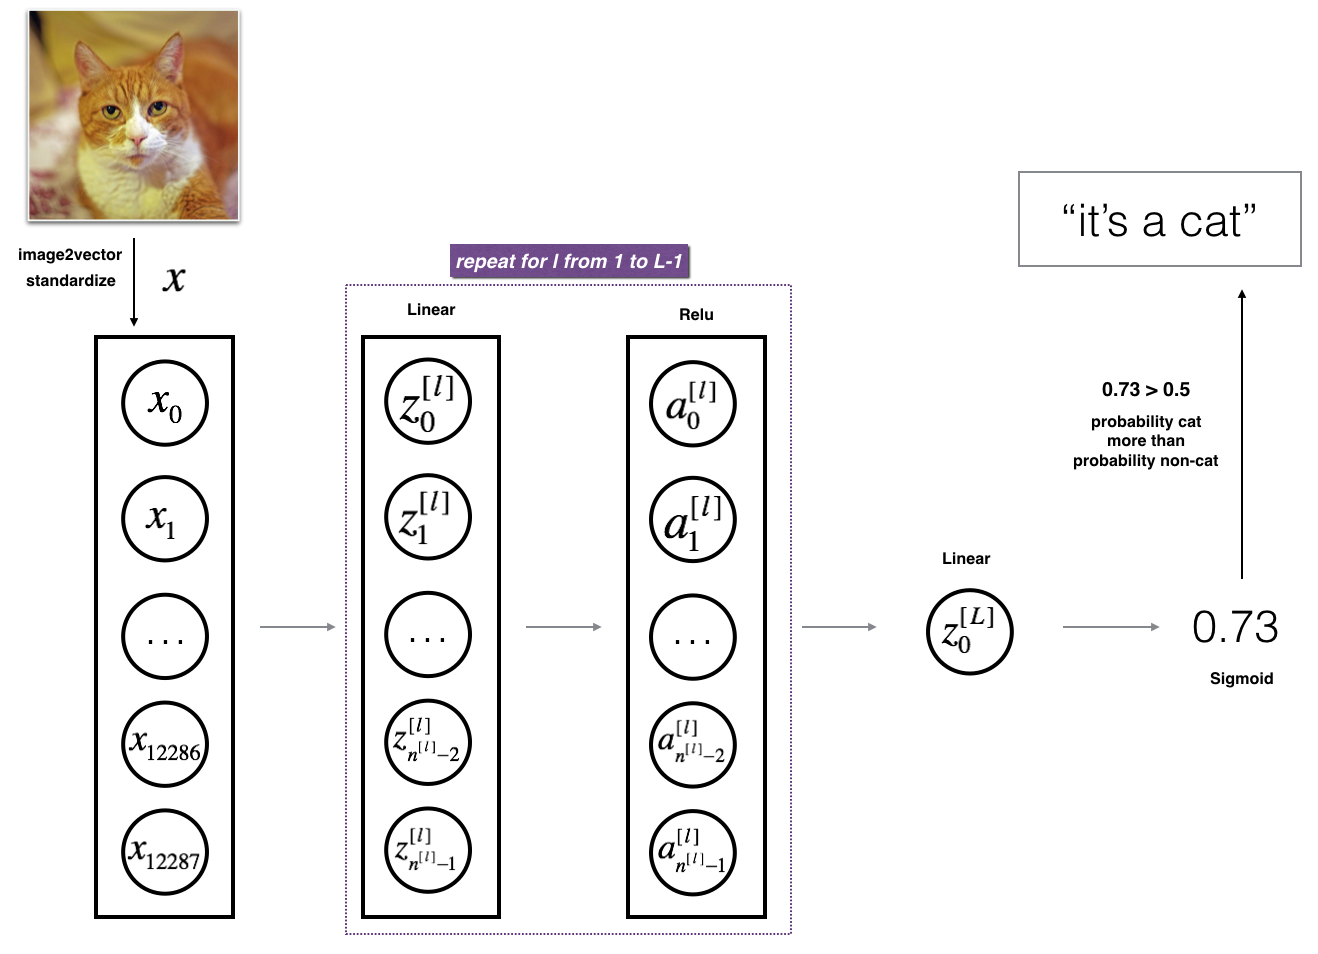
<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 3</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</font></center></caption>

<u><b>Detailed Architecture of Figure 3</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

<a name='3-3'></a>
### 3.3 - General Methodology

As usual, you'll follow the Deep Learning methodology to build the model:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

Now go ahead and implement those two models!

<a name='4'></a>
## 4 - Two-layer Neural Network

<a name='ex-1'></a>
### Exercise 1 - two_layer_model 

Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [9]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [10]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # YOUR CODE ENDS HERE
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        # A1, cache1 = ...
        # A2, cache2 = ...
        # YOUR CODE STARTS HERE
        
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # YOUR CODE ENDS HERE
        
        # Compute cost
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        
        cost = compute_cost(A2, Y)
        
        # YOUR CODE ENDS HERE
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        # dA1, dW2, db2 = ...
        # dA0, dW1, db1 = ...
        # YOUR CODE STARTS HERE
        
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # YOUR CODE ENDS HERE
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        #(approx. 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        
        parameters = update_parameters(parameters, grads, learning_rate) 
        
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [11]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

two_layer_model_test(two_layer_model)

Cost after iteration 1: 0.6926114346158595
Cost after first iteration: 0.693049735659989
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 2: 0.6524135179683452
 All tests passed.


**Expected output:**

```
cost after iteration 1 must be around 0.69
```

<a name='4-1'></a>
### 4.1 - Train the model 

If your code passed the previous cell, run the cell below to train your parameters. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.5158304772764731
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.2468176821061484
Cost after iteration 1400: 0.19850735037466105
Cost after iteration 1500: 0.17448318112556638
Cost after iteration 1600: 0.17080762978097447
Cost after iteration 1700: 0.11306524562164699
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726872
Cost after iteration 2000: 0.07439078704319087
Cost after iteration 2100: 0.0663074813

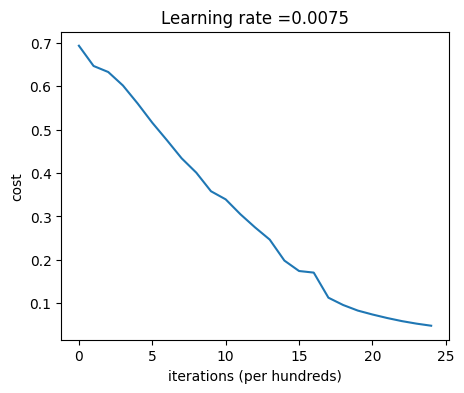

In [12]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.04421498215868956 </td>
    </tr>
</table>

**Nice!** You successfully trained the model. Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [18]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Expected Output**:
<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.9999999999999998 </td>
    </tr>
</table>

In [19]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:

<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.72 </td>
    </tr>
</table>

### Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an $L$-layer model.

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and you'll hear more about it in the next course. Early stopping is a way to prevent overfitting. 

<a name='5'></a>
## 5 - L-layer Neural Network

<a name='ex-2'></a>
### Exercise 2 - L_layer_model 

Use the helper functions you implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [15]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [20]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    
    parameters = initialize_parameters_deep(layers_dims)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        
        AL, caches = L_model_forward(X, parameters)
        
        # YOUR CODE ENDS HERE
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        
        cost = compute_cost(AL, Y)
        
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        
        grads = L_model_backward(AL, Y, caches)
        
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [21]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

L_layer_model_test(L_layer_model)

Cost after iteration 0: 0.7717493284237686
Cost after first iteration: 0.7717493284237686
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 2: 0.7063462654190897
 All tests passed.


<a name='5-1'></a>
### 5.1 - Train the model 

If your code passed the previous cell, run the cell below to train your model as a 4-layer neural network. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

In [22]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366112
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.4654773771766851
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805356
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.16118854665827748
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.1377748781297294
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.11382060668633709
Cost after iteration 2100: 0.1078392

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.088439 </td>
    </tr>
</table>

In [23]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


**Expected Output**:

<table>
    <tr>
    <td>
        <b>Train Accuracy</b>
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [24]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Expected Output**:

<table> 
    <tr>
        <td> <b>Test Accuracy</b></td>
        <td> 0.8 </td>
    </tr>
</table>

### Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is pretty good performance for this task. Nice job! 

In the next course on "Improving deep neural networks," you'll be able to obtain even higher accuracy by systematically searching for better hyperparameters: learning_rate, layers_dims, or num_iterations, for example.  

<a name='6'></a>
##  6 - Results Analysis

First, take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

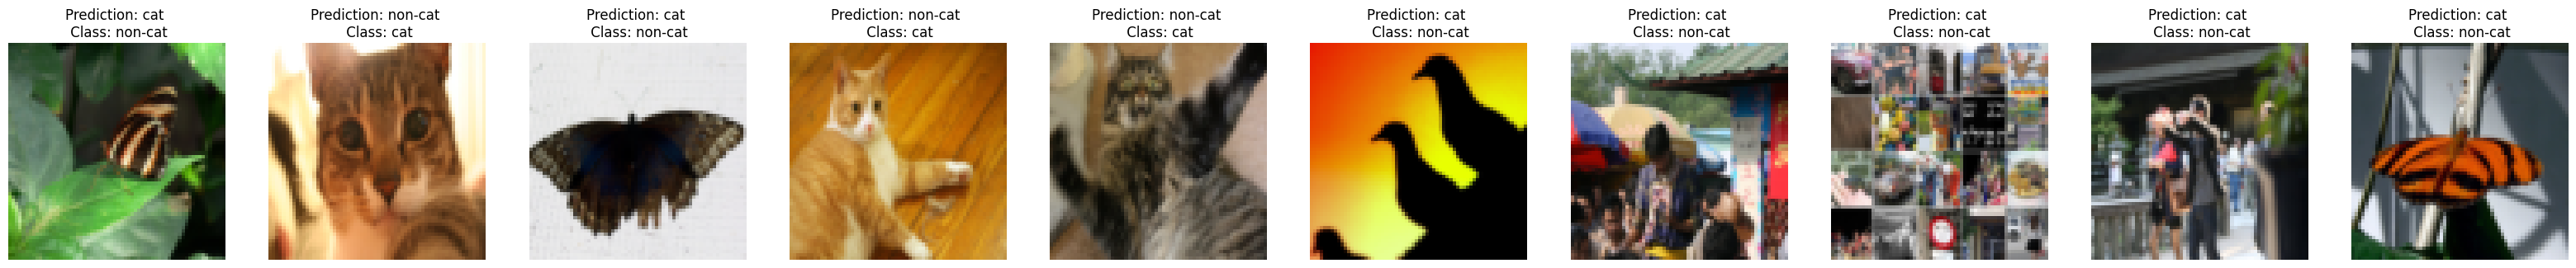

In [25]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### Congratulations on finishing this assignment! 

You just built and trained a deep L-layer neural network, and applied it in order to distinguish cats from non-cats, a very serious and important task in deep learning. ;) 

By now, you've also completed all the assignments for Course 1 in the Deep Learning Specialization. Amazing work! If you'd like to test out how closely you resemble a cat yourself, there's an optional ungraded exercise below, where you can test your own image. 

Great work and hope to see you in the next course! 

<a name='7'></a>
## 7 - Test with your own image (optional/ungraded exercise) ##

From this point, if you so choose, you can use your own image to test  the output of your model. To do that follow these steps:

1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Change your image's name in the following code
4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


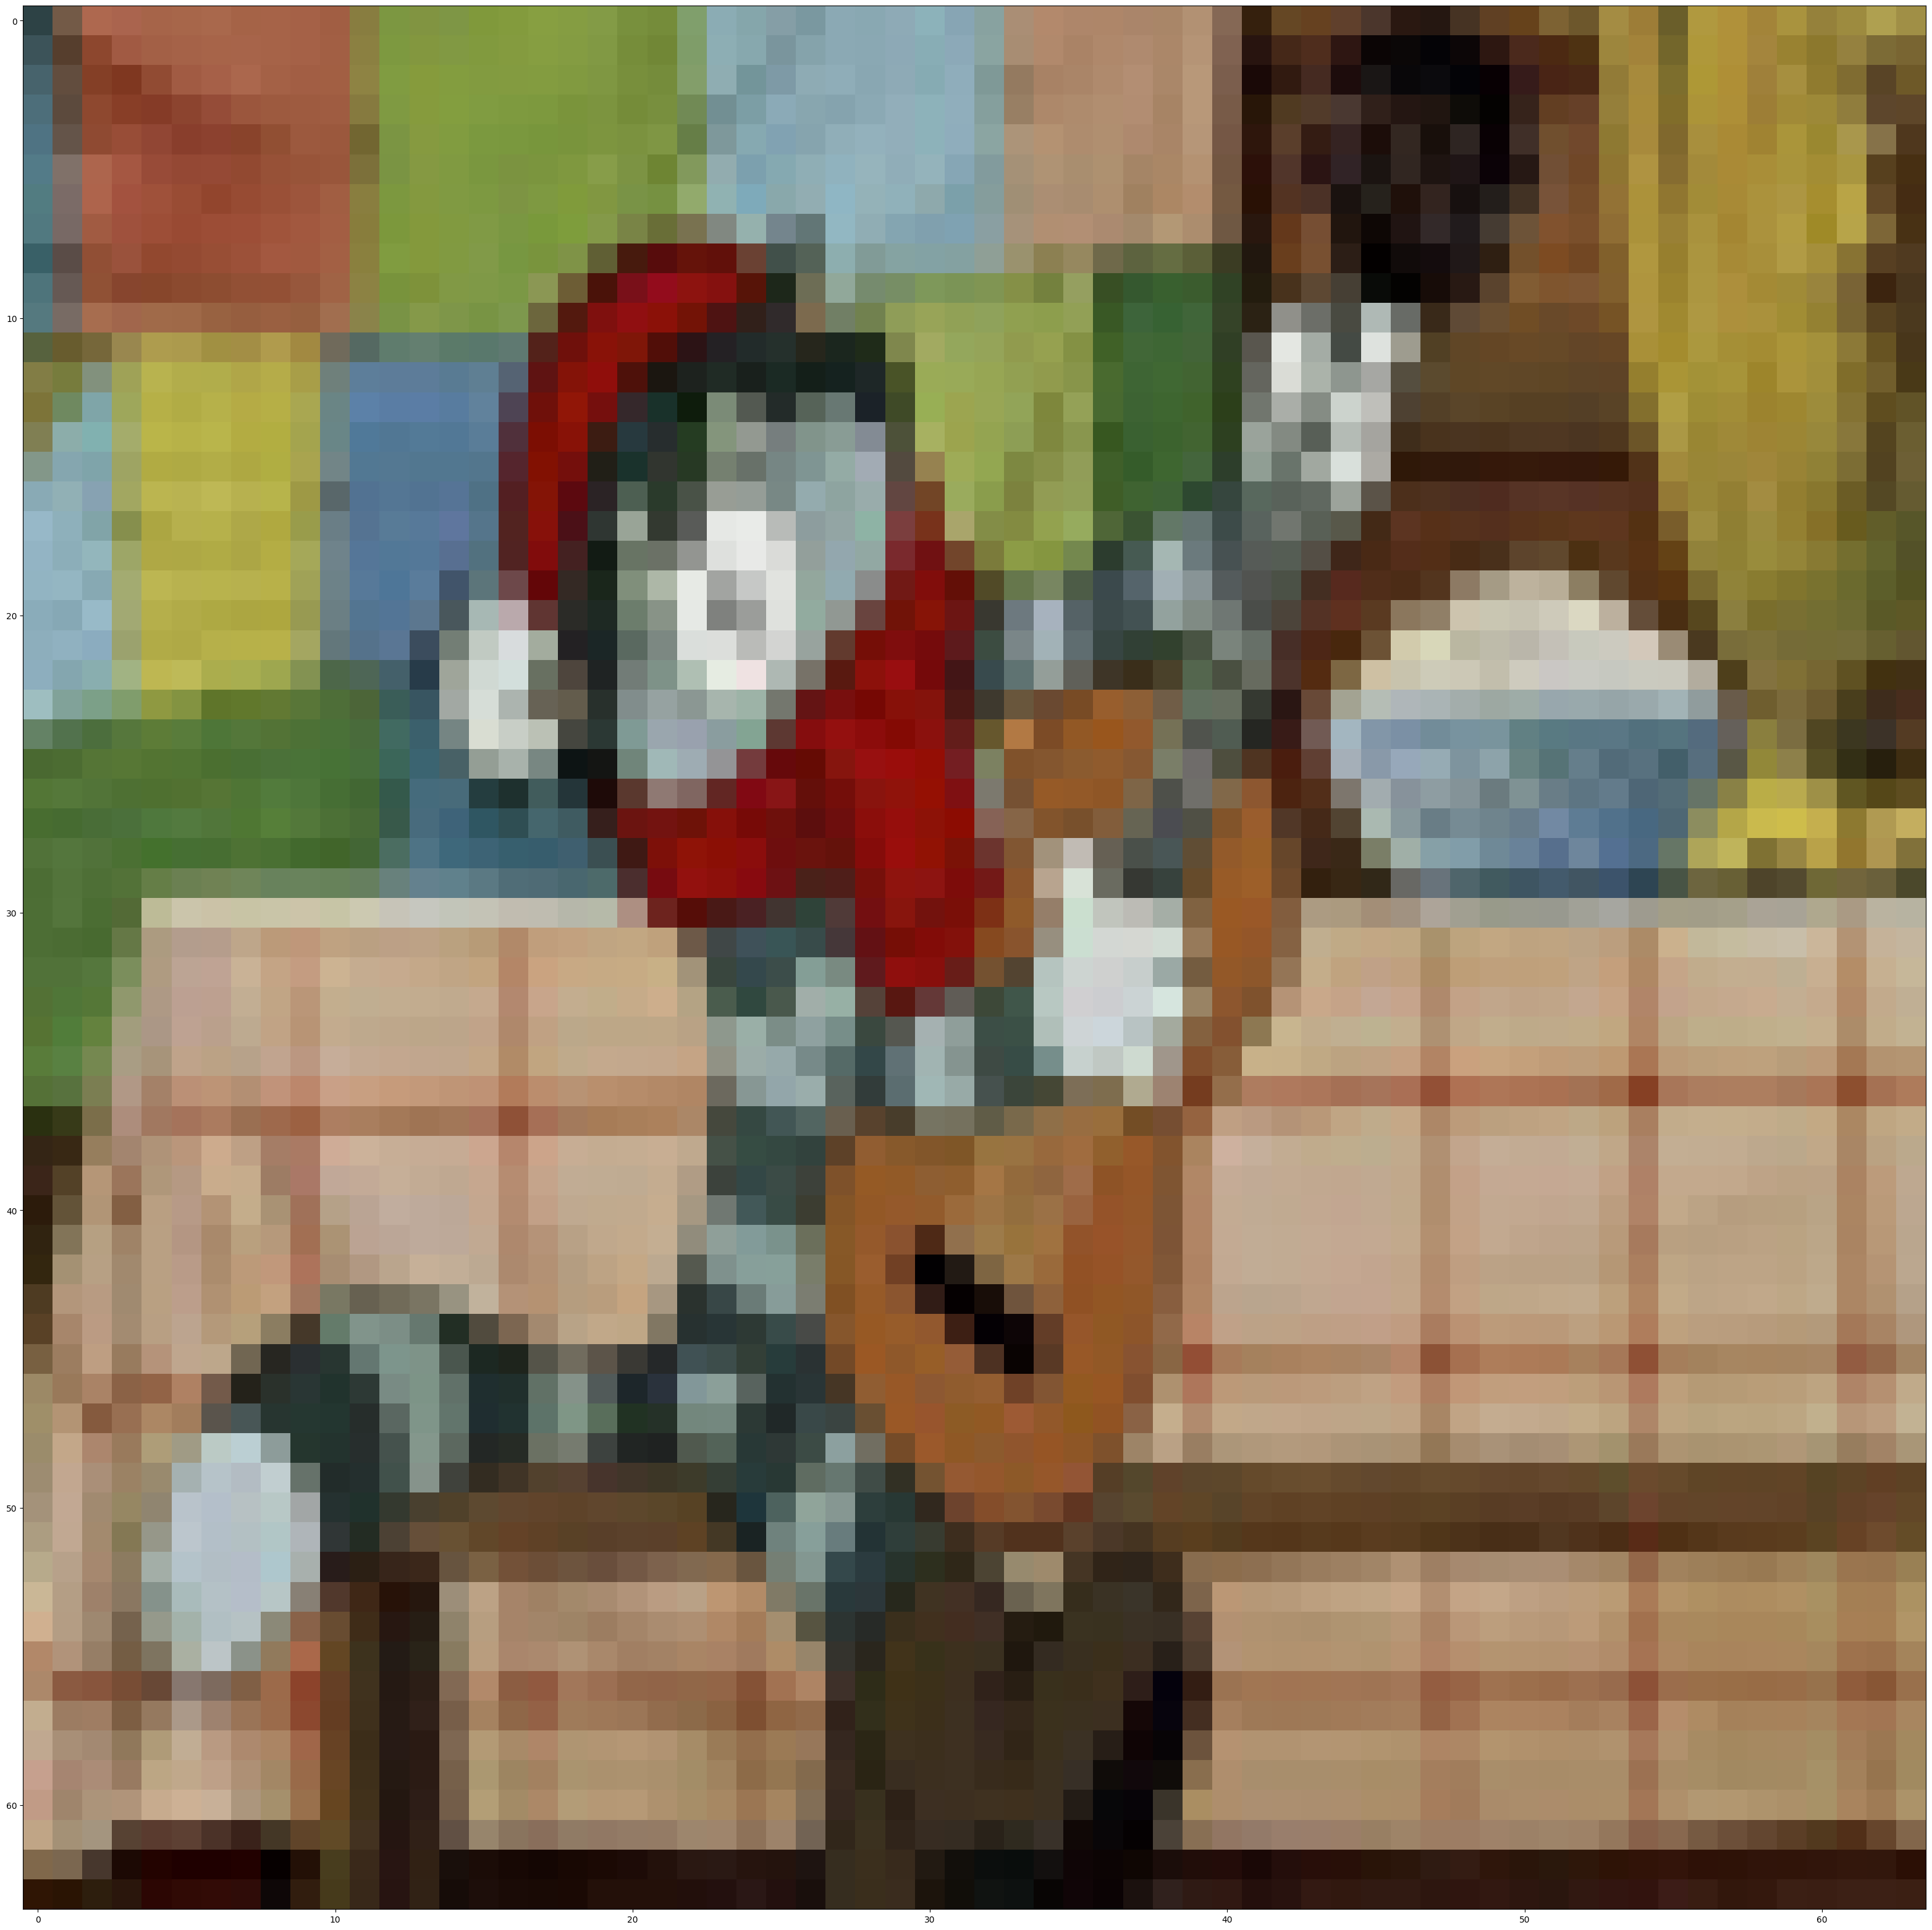

In [28]:
from PIL import Image

## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = 'Матроскин.jpg'
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython